In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/drive/MyDrive/Food_facts/world-food-facts.csv'
df = pd.read_csv(file_path)
df.head()

# Simpan ke file JSON
df.to_json('food_data_ready.json', orient='records', indent=2)

# Unduh file
files.download('food_data_ready.json')

In [ ]:
# Cek dan bersihkan data
df.info()
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        5 non-null      object 
 1   energy_100g         5 non-null      int64  
 2   fat_100g            5 non-null      float64
 3   sugars_100g         5 non-null      float64
 4   fiber_100g          5 non-null      float64
 5   proteins_100g       5 non-null      float64
 6   salt_100g           5 non-null      float64
 7   nutrition_grade_fr  5 non-null      object 
dtypes: float64(5), int64(1), object(2)
memory usage: 452.0+ bytes


,product_name,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_grade_fr
0,Salad Sayuran,45,0.5,2.5,3.0,1.2,0.01,a
1,Keripik Kentang,550,35.0,2.0,2.0,6.5,1.60,e
2,Yogurt Rendah Lemak,60,1.5,4.0,0.0,3.0,0.10,b
3,Cokelat Susu,550,30.0,50.0,1.0,5.0,0.30,d
4,Apel,52,0.2,10.0,2.4,0.3,0.01,a


In [ ]:
# Lihat kolom yang tersedia
print(df.columns)


Index(['product_name', 'energy_100g', 'fat_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'nutrition_grade_fr'],
      dtype='object')


In [ ]:
# Buat label biner: Positif (rating >= a), Negatif (rating <= c), netral dihapus

if 'rating' in df.columns:
    df['nutrition_grade_fr'] = pd.to_numeric(df['nutrition_grade_fr'], errors='coerce')
    df = df.dropna(subset=['nutrition_grade_fr'])
    df['product_name'] = df['nutrition_grade_fr'].apply(lambda x: 1 if x >= 4 else 0)
else:
    print("Kolom 'Nutrisi' tidak ditemukan dalam DataFrame.")


In [ ]:
#  TF-IDF vektorisasi teks ulasan
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['nutrition_grade_fr'])

# Target label
y = df['product_name']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Training model Decision Tree
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Accuracy: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

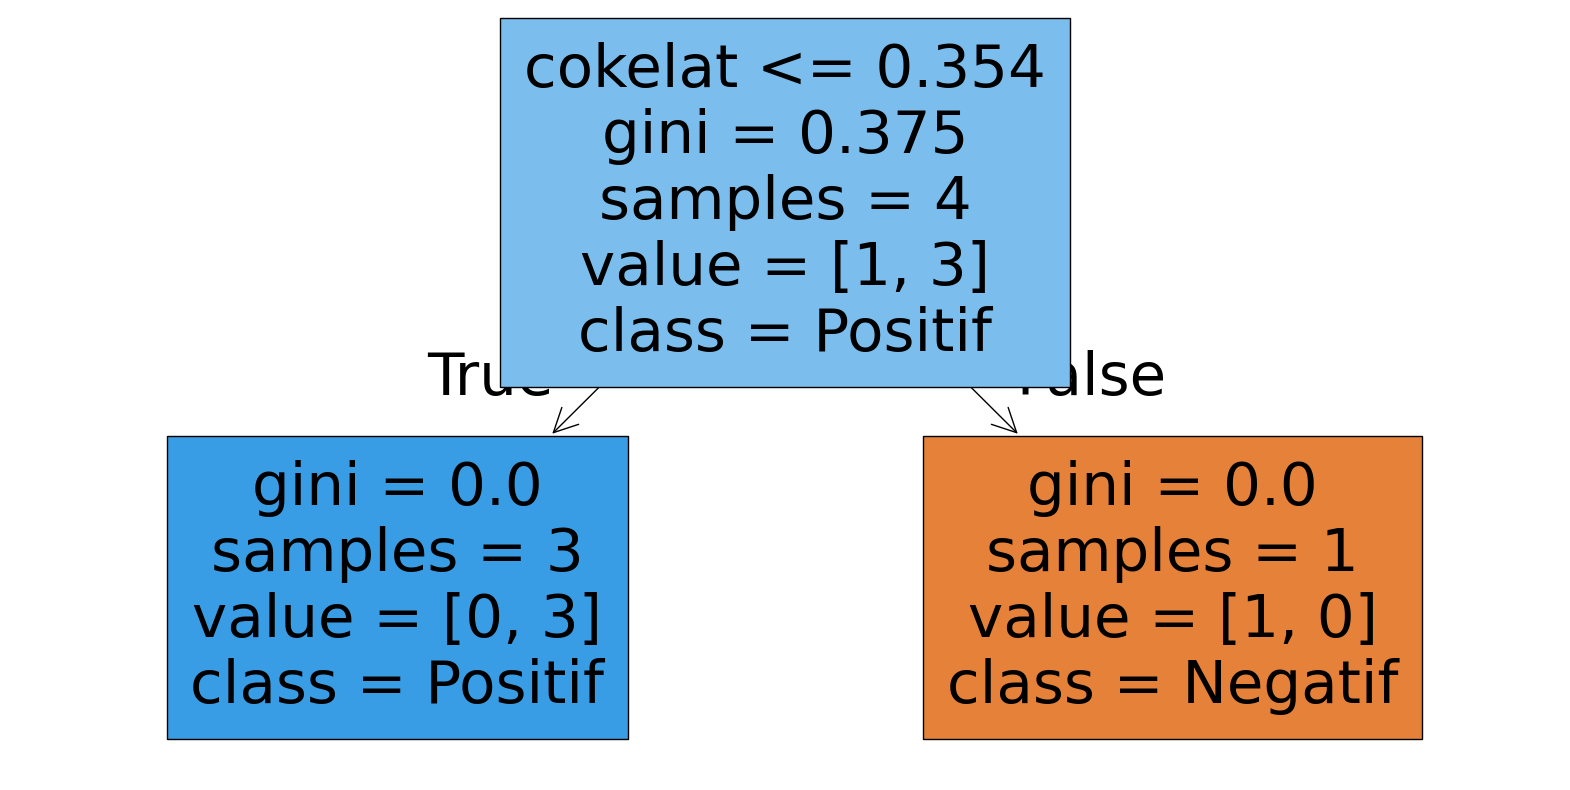

In [ ]:
#  Visualisasi tree
plt.figure(figsize=(20,10))
plot_tree(model, max_depth=2, feature_names=vectorizer.get_feature_names_out(), class_names=['Negatif', 'Positif'], filled=True)
plt.show()


In [ ]:
# Rekomendasi berdasarkan kesamaan ulasan (cosine similarity)
tfidf_matrix = vectorizer.fit_transform(df['product_name'])
cos_sim = cosine_similarity(tfidf_matrix)

# Fungsi rekomendasi
def recommend_reviews(index, top_n=5):
    scores = list(enumerate(cos_sim[index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    recommended_idx = [i[0] for i in scores[1:top_n+1]]
    return df.iloc[recommended_idx][['product_name', 'nutrition_grade_fr']]



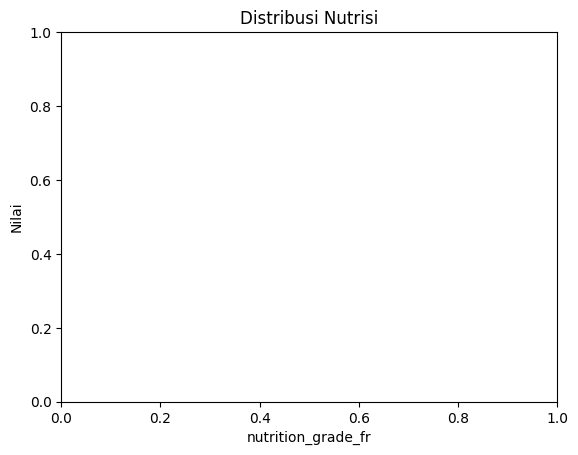

In [ ]:
df['nutrition_grade_fr'] = pd.to_numeric(df['nutrition_grade_fr'], errors='coerce')

# Filter the DataFrame
filtered_df = df[df['nutrition_grade_fr'] <= 5.0]

sns.countplot(x='nutrition_grade_fr', data=filtered_df)
plt.title('Distribusi Nutrisi')
plt.xlabel('nutrition_grade_fr')
plt.ylabel('Nilai')
plt.show()

In [ ]:
import re
import string

# Drop baris kosong
df = df.dropna(subset=['product_name', 'nutrition_grade_fr'])

# Label Sentimen: Positif (>=4), Negatif (<=2), Netral (3) dihapus
df = df[df['nutrition_grade_fr'] != 3]
df['product_name'] = df['nutrition_grade_fr'].apply(lambda x: 1 if x >= 4 else 0)

# Preprocessing teks
def clean_text(text):
    text = text.lower()  # huruf kecil semua
    text = re.sub(r'http\S+', '', text)  # hapus link
    text = re.sub(r'@\w+|#\w+', '', text)  # hapus mention & hashtag
    text = re.sub(r'[^\w\s]', '', text)  # hapus tanda baca
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.strip()  # hapus spasi di awal/akhir
    return text

df['clean_text'] = df['nutrition_grade_fr'].apply(clean_text)
df[['nutrition_grade_fr', 'clean_text']].head()


,nutrition_grade_fr,clean_text


In [ ]:
# Akurasi dan laporan klasifikasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_